# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'idx_layer' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data acquisition

First we download a sample multiome dataset from 10X. We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.


```{important}
MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.
```

Next, we'll read the data into an Mudata object, which is a container for multiple AnnData objects.

Reading the data into an MuData object can be done with the muon `read_10x_h5` function:

```{note}
We could have also used Anndata object. However, this is less recommended starting v1.2.1 and we aim that the use of anndata with MultiVI will be deprecated starting scvi-tools v1.4.0. To see MultiVI Anndata tutorial, see RTD previous versions.
```

In [5]:
# read multiomic data
url = "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/10k_PBMC_Multiome_nextgem_Chromium_X/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"
mdata = muon.read_10x_h5("data/multiome10k.h5mu", backup_url=url)

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/multiome10k.h5mu


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from 

In [6]:
# We add batch artificially for this tutorial purpose
mdata["rna"].obs["batch"] = ["batch_0"] * int(mdata.n_obs / 2) + ["batch_1"] * (
    mdata.n_obs - int(mdata.n_obs / 2)
)

In [7]:
# We also add size factor to be used during minification later in this tutorial
mdata.obs["size_factor_rna"] = mdata["rna"].X.sum(1)
mdata.obs["size_factor_atac"] = (mdata["atac"].X.sum(1) + 1) / (
    np.max(mdata["atac"].X.sum(1)) + 1.01
)

In [8]:
mdata

MuData object with n_obs × n_vars = 10970 × 148344
  obs:	'size_factor_rna', 'size_factor_atac'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10970 x 36601
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

We can see that there are 2 modalities in this multiome data, rna and atac. For more information on this dataset: [sample multiome data from 10X of 10K PBMCs](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0).

## Data Processing

We can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks & genes that are rarely detected, to make the model train faster. In this case we keep the top 4000 for each modality and filter out non-chromosomal regions. 
We store those in a new modality for reproducibility.

In [9]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
)
mdata.mod["rna_subset"] = mdata.mod["rna"][:, mdata.mod["rna"].var["highly_variable"]].copy()
# Filter out non-chromosomal regions
mask = mdata.mod["rna_subset"].var["interval"].str.startswith("chr")
mdata.mod["rna_subset"] = mdata.mod["rna_subset"][:, mask].copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
sc.pp.highly_variable_genes(
    mdata.mod["atac"],
    n_top_genes=4000,
    flavor="seurat_v3",
)
mdata.mod["atac_subset"] = mdata.mod["atac"][:, mdata.mod["atac"].var["highly_variable"]].copy()
# Filter out non-chromosomal regions
mask = mdata.mod["atac_subset"].var["interval"].str.startswith("chr")
mdata.mod["atac_subset"] = mdata.mod["atac_subset"][:, mask].copy()

In [11]:
mdata.update()

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are

In [12]:
mdata

MuData object with n_obs × n_vars = 10970 × 156340
  obs:	'size_factor_rna', 'size_factor_atac'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  4 modalities
    rna:	10970 x 36601
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    rna_subset:	10970 x 4001
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac_subset:	10970 x 3995
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'

In [13]:
mdata.mod["rna_subset"].var

,gene_ids,feature_types,genome,interval,highly_variable,highly_variable_rank,means,variances,variances_norm
HES4,ENSG00000188290,Gene Expression,GRCh38,chr1:999980-1000172,True,210.0,0.063446,0.173748,2.174311
ISG15,ENSG00000187608,Gene Expression,GRCh38,chr1:1001137-1013497,True,848.0,0.204102,0.426294,1.466590
TNFRSF18,ENSG00000186891,Gene Expression,GRCh38,chr1:1205679-1206592,True,1859.0,0.036554,0.056736,1.263666
TNFRSF4,ENSG00000186827,Gene Expression,GRCh38,chr1:1214152-1214153,True,2126.0,0.053965,0.082601,1.226946
AL162741.1,ENSG00000260179,Gene Expression,GRCh38,chr1:1251333-1251334,True,3940.0,0.001003,0.001184,1.105230
...,...,...,...,...,...,...,...,...,...
LINC00278,ENSG00000231535,Gene Expression,GRCh38,chrY:3002886-3003001,True,3015.0,0.390246,0.750511,1.153820
AC010737.1,ENSG00000229308,Gene Expression,GRCh38,chrY:4036496-4036497,True,921.0,0.000365,0.000547,1.446148
NLGN4Y,ENSG00000165246,Gene Expression,GRCh38,chrY:14522751-14524574,True,1655.0,0.019508,0.030616,1.289717
TTTY14,ENSG00000176728,Gene Expression,GRCh38,chrY:19076023-19077395,True,255.0,0.146855,0.406821,2.044043


In [14]:
mdata.mod["atac_subset"].var

,gene_ids,feature_types,genome,interval,highly_variable,highly_variable_rank,means,variances,variances_norm
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,True,1603.0,1.308751,4.189740,1.232472
chr1:1098910-1099873,chr1:1098910-1099873,Peaks,GRCh38,chr1:1098910-1099873,True,799.0,0.296809,0.935326,1.287371
chr1:1201046-1201913,chr1:1201046-1201913,Peaks,GRCh38,chr1:1201046-1201913,True,3971.0,0.891796,2.632014,1.169175
chr1:1216749-1217579,chr1:1216749-1217579,Peaks,GRCh38,chr1:1216749-1217579,True,1471.0,0.219690,0.656080,1.238325
chr1:1629814-1630730,chr1:1629814-1630730,Peaks,GRCh38,chr1:1629814-1630730,True,2596.0,1.805925,5.822209,1.197963
...,...,...,...,...,...,...,...,...,...
chrY:56727693-56728598,chrY:56727693-56728598,Peaks,GRCh38,chrY:56727693-56728598,True,2097.0,0.002370,0.005464,1.211180
chrY:56734351-56735237,chrY:56734351-56735237,Peaks,GRCh38,chrY:56734351-56735237,True,42.0,0.004467,0.015022,1.694357
chrY:56763067-56763960,chrY:56763067-56763960,Peaks,GRCh38,chrY:56763067-56763960,True,53.0,0.002461,0.007743,1.648426
chrY:56836418-56837345,chrY:56836418-56837345,Peaks,GRCh38,chrY:56836418-56837345,True,254.0,0.026800,0.080237,1.382211


In [15]:
mdata.mod["atac_subset"].var.interval.nunique()

3995

## Setup and Training MultiVI

We can now set up and train the MultiVI model!

Now we run `setup_mudata`, which is the MuData analog to `setup_anndata`. The caveat of this workflow is that we need to provide this function which modality of the `mdata` object contains each piece of data. 
So for example, if the batch information is in `mdata.mod["rna"].obs["batch"]`, in the `modalities` argument we specify that the `batch_key` can be found in the `"rna_subset"` modality of the MuData object (see example in the TotalVI tutorial).

In our case, the main batch annotation, by mudata definition, correspond to the modality of the cells.


```{important}
MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.
```

In [16]:
scvi.model.MULTIVI.setup_mudata(
    mdata,
    batch_key="batch",  # the batch is here: mdata.mod["rna_subset"].obs["batch"]
    size_factor_key=["size_factor_rna", "size_factor_atac"],
    modalities={
        "rna_layer": "rna_subset",
        "atac_layer": "atac_subset",
        "batch_key": "rna_subset",
    },
)

```{note}
Specify the modality of each argument via the `modalities` dictionary, which maps layer/key arguments to MuData modalities.
```

Prepare and run the model

In [17]:
model = scvi.model.MULTIVI(mdata)

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [18]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'rna_layer': None,
│   'atac_layer': None,
│   'protein_layer': None,
│   'batch_key': 'batch',
│   'size_factor_key': ['size_factor_rna', 'size_factor_atac'],
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna_subset', 'atac_layer': 'atac_subset', 'batch_key': 'rna_subset'}
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_atac          │ 3995  │
│         n_batch          │   2   │
│         n_cells          │ 10970 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│      n_size_factor       │   2   │
│          n_vars          │ 4001  │
└──────────────────────────┴───────┘

                        Data Registry                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │         adata.mod['rna_subset'].X          │
│     atac     │         adata.mod['atac_subset'].X         │
│    batch     │ adata.mod['rna_subset'].obs['_scvi_batch'] │
│    ind_x     │           adata.obs['_indices']            │
│    labels    │         adata.obs['_scvi_labels']          │
│ size_factor  │      adata.obsm['_scvi_size_factor']       │
└──────────────┴────────────────────────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │  batch_0   │          0          │
│                    │  batch_1   │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

   size_factor State Registry    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['size_factor_rna']  │
│ adata.obs['size_factor_atac'] │
└───────────────────────────────┘

In [19]:
model.train()

/var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/ipykernel_66575/1676823408.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/ligh

Training:   0%|          | 0/500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


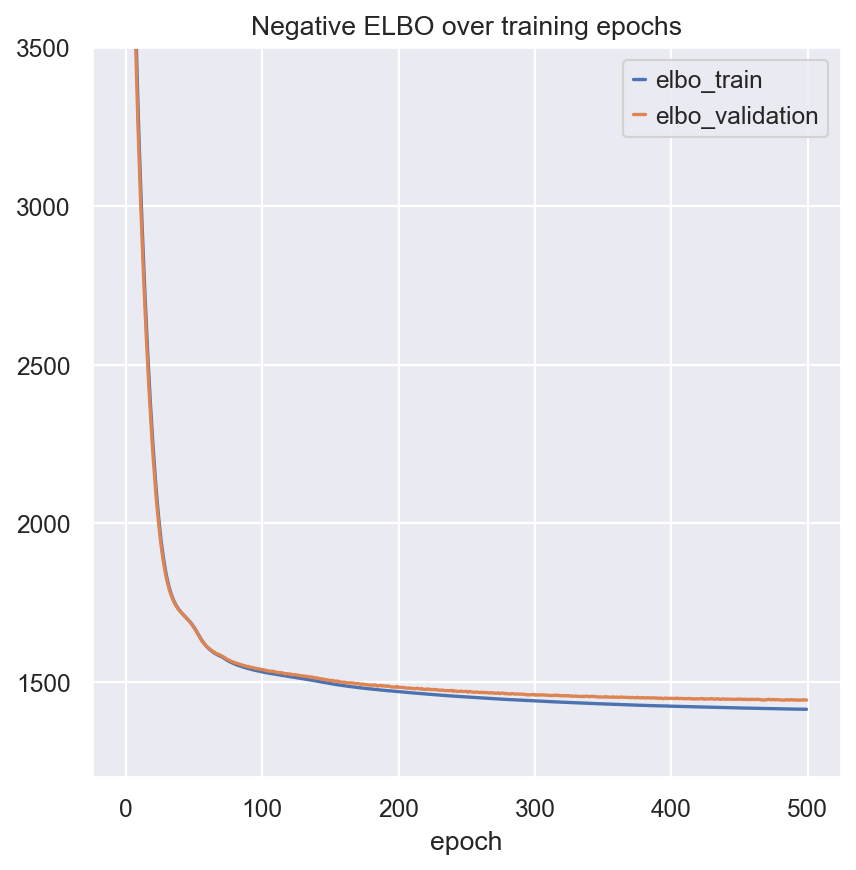

In [20]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(1200, 3500))
ax.legend()

## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [21]:
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")

model.save(model_dir, overwrite=True, save_anndata=True)

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from ind

In [22]:
model.view_setup_args(os.path.join(save_dir.name, "multivi_pbmc10k"))

INFO     File /var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/tmpckri987f/multivi_pbmc10k/model.pt already        
         downloaded                                                                                                


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_loc

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'rna_layer': None,
│   'atac_layer': None,
│   'protein_layer': None,
│   'batch_key': 'batch',
│   'size_factor_key': ['size_factor_rna', 'size_factor_atac'],
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna_subset', 'atac_layer': 'atac_subset', 'batch_key': 'rna_subset'}
}

In [23]:
model_loaded = scvi.model.MULTIVI.load(model_dir, adata=mdata)

INFO     File /var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/tmpckri987f/multivi_pbmc10k/model.pt already        
         downloaded                                                                                                


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_loc

## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

In [24]:
MULTIVI_LATENT_KEY = "X_multivi"
MULTIVI_CLUSTERS_KEY = "leiden_mutliVI"
mdata.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
mdata.update()

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from ind

/var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/ipykernel_66575/16395450.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata, key_added=MULTIVI_CLUSTERS_KEY)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguit

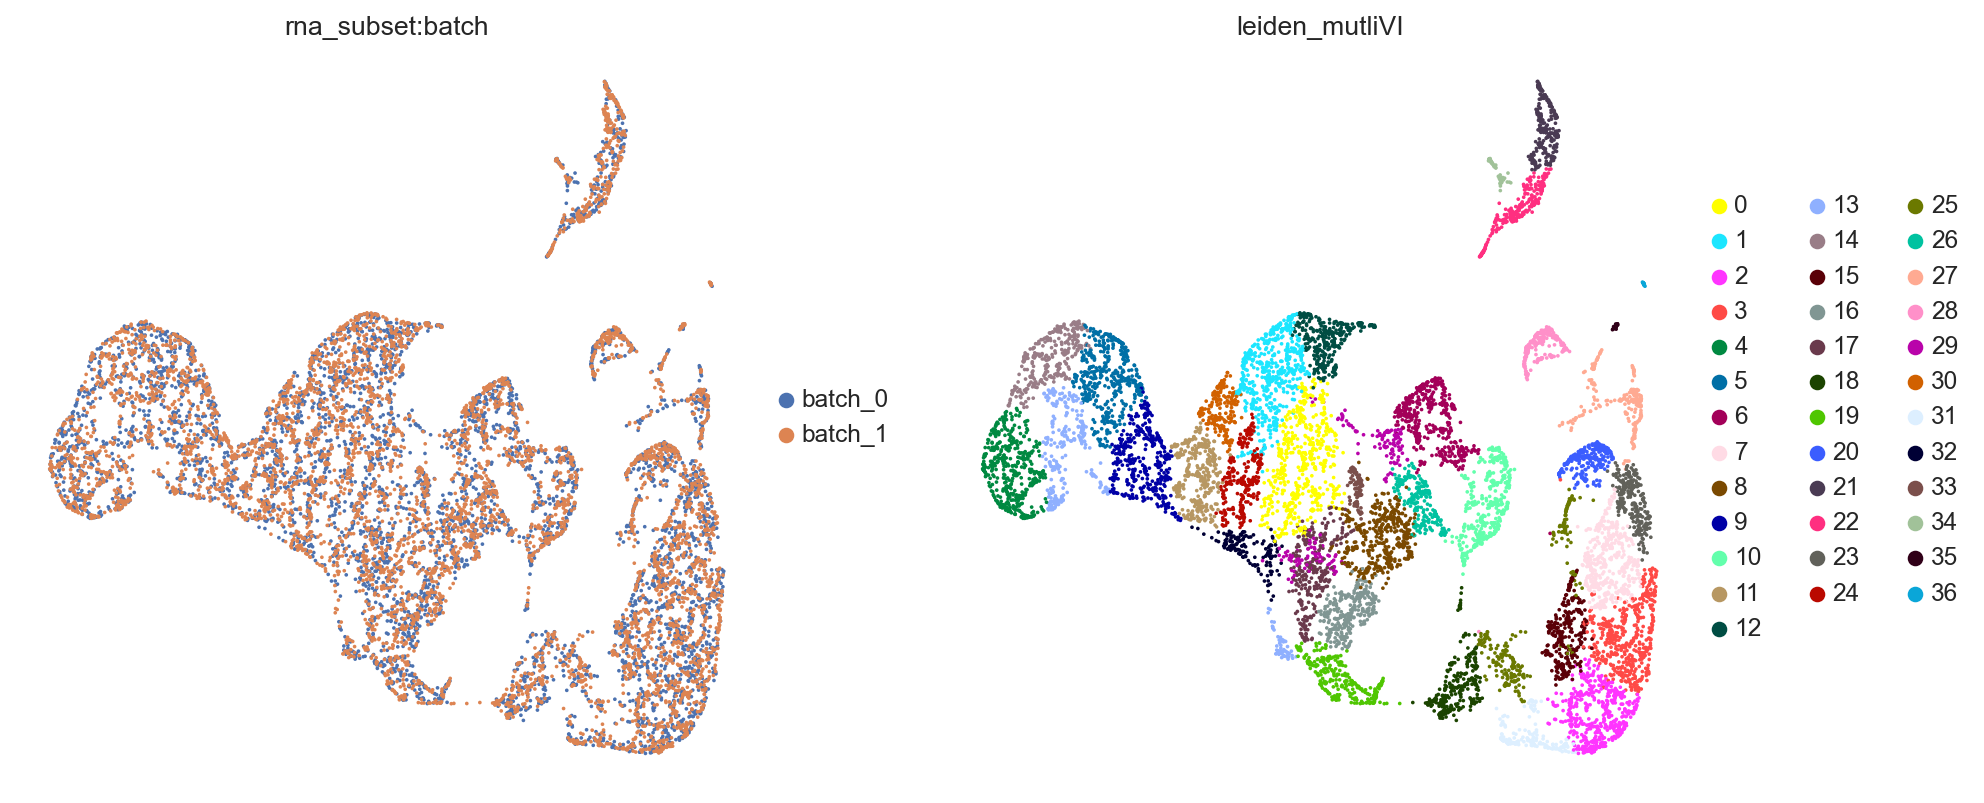

In [25]:
sc.pp.neighbors(mdata, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(mdata, min_dist=0.2)
sc.tl.leiden(mdata, key_added=MULTIVI_CLUSTERS_KEY)
mdata.update()
sc.pl.umap(mdata, color=["rna_subset:batch", "leiden_mutliVI"])

muon has another plotting functions which can pull data from either modality of the MuData object.

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [26]:
imputed_expression = model.get_normalized_expression()

We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

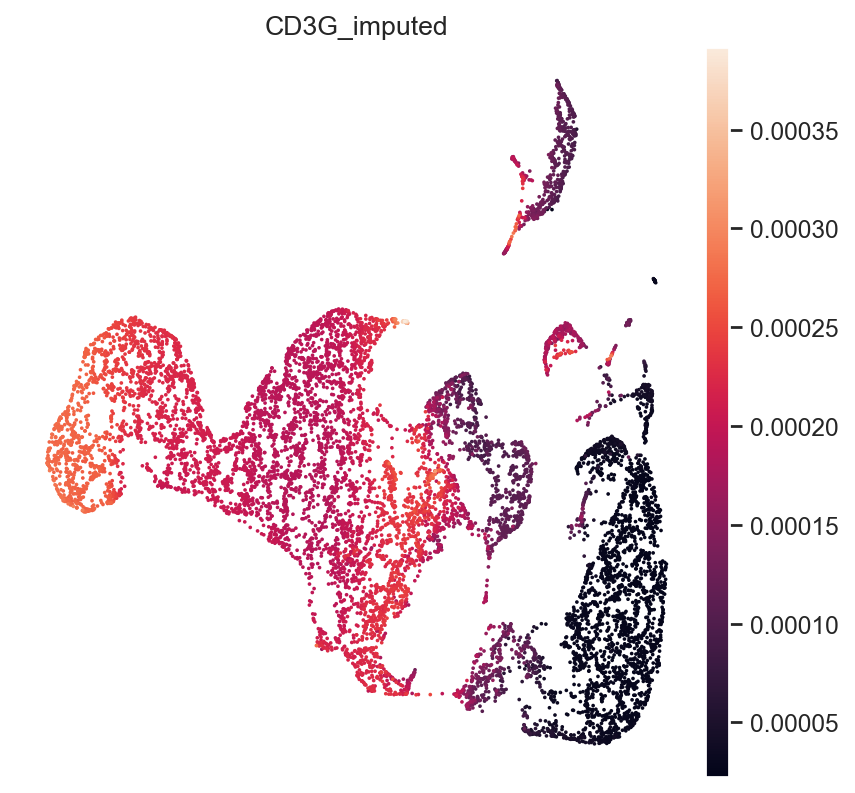

In [27]:
gene_idx = np.where(mdata["rna_subset"].var.index == "CD3G")[0]
mdata.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="CD3G_imputed")

Next, NK-Cell marker gene NCAM1 (CD56):

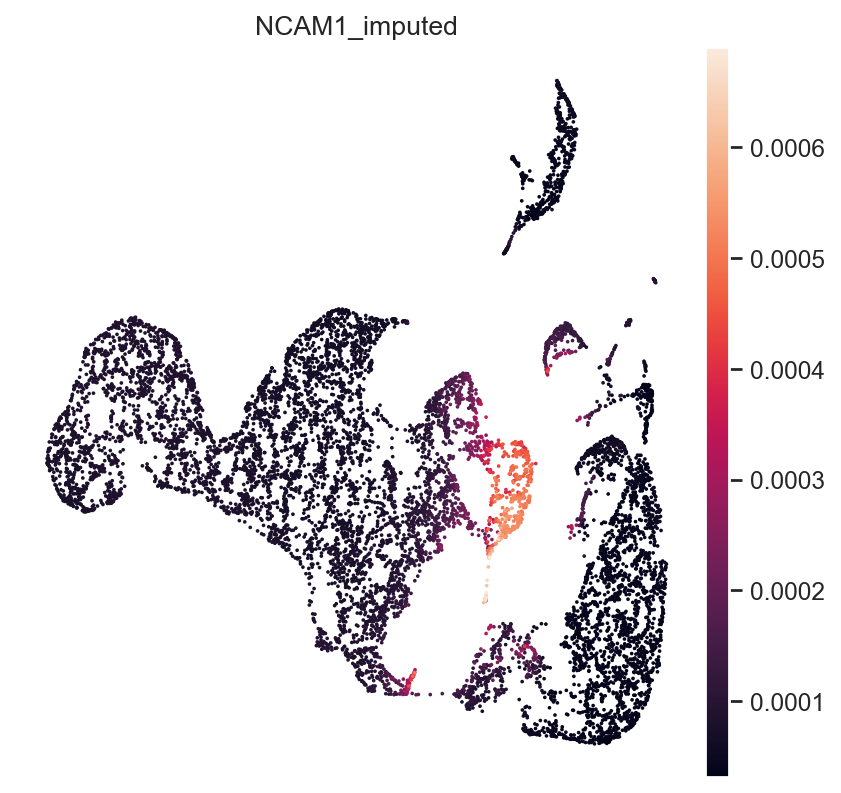

In [28]:
gene_idx = np.where(mdata["rna_subset"].var.index == "NCAM1")[0]
mdata.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="NCAM1_imputed")

Finally, B-Cell Marker CD19:

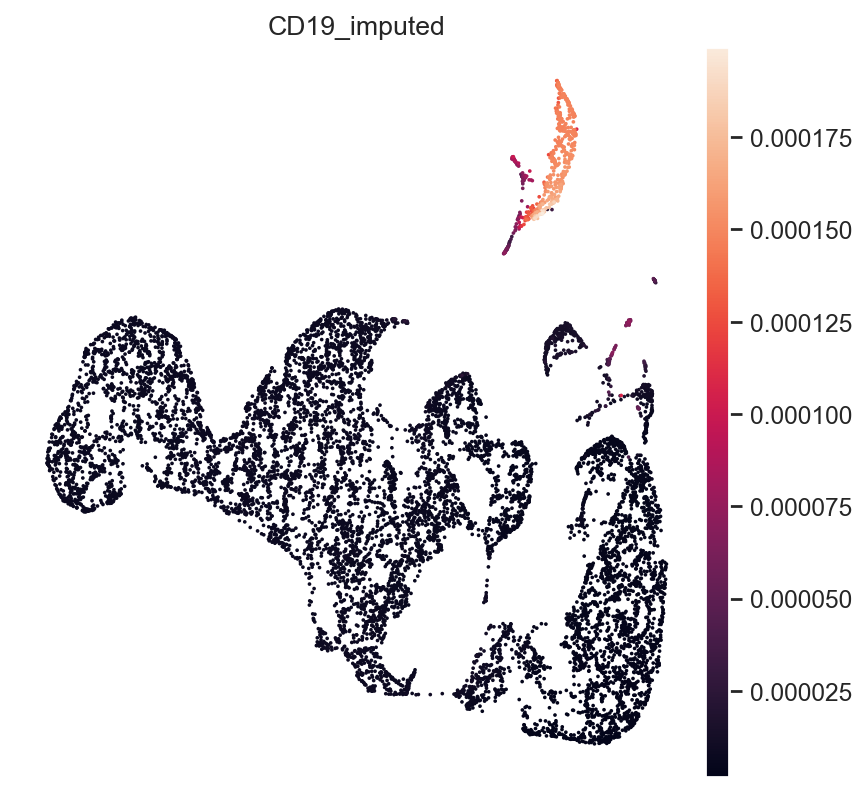

In [29]:
gene_idx = np.where(mdata["rna_subset"].var.index == "CD19")[0]
mdata.obs["CD19_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(mdata, color="CD19_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.

## Minification of MultiVI models


We will show here how to apply minification to the mudata of the trained multivi model. The reader is first encouraged to read the minification tutorial, which can be found here: (https://docs.scvi-tools.org/en/stable/tutorials/notebooks/hub/minification..html) 

In [30]:
model

MultiVI Model with the following params: 
n_genes: 4001, n_regions: 3995, n_proteins: 0, n_hidden: 63, n_latent: 7, n_layers_encoder: 2, n_layers_decoder: 2,
dropout_rate: 0.1, latent_distribution: normal, deep injection: False, gene_likelihood: zinb, gene_dispersion:gene,
Mod.Weights: equal, Mod.Penalty: Jeffreys, protein_dispersion: protein
Training status: Trained
Model's adata is minified?: False
Model's adata is minified?: False

Let's also save a reference to `model.adata`. We'll see later that this remains unchanged because **minification is not an inplace procedure**.

In [31]:
bdata = model.adata

Note that, as expected, "Model's adata is minified" is False.

To minify the data, all we need to do is:

1. get the latent representation and store it in the mudata
1. call `model.minify_mudata()`

In [32]:
qzm, qzv = model.get_latent_representation(give_mean=False, return_dist=True)
model.adata.obsm["X_latent_qzm"] = qzm
model.adata.obsm["X_latent_qzv"] = qzv

model.minify_mudata()

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [33]:
model

MultiVI Model with the following params: 
n_genes: 4001, n_regions: 3995, n_proteins: 0, n_hidden: 63, n_latent: 7, n_layers_encoder: 2, n_layers_decoder: 2,
dropout_rate: 0.1, latent_distribution: normal, deep injection: False, gene_likelihood: zinb, gene_dispersion:gene,
Mod.Weights: equal, Mod.Penalty: Jeffreys, protein_dispersion: protein
Training status: Trained
Model's adata is minified?: True
Model's adata is minified?: True

As expected, "Model's adata is minified" is now True. Also, we can check the model's `minified_data_type`:

In [34]:
model.minified_data_type

'latent_posterior_parameters'

In [35]:
model.adata

MuData object with n_obs × n_vars = 10970 × 156340
  obs:	'size_factor_rna', 'size_factor_atac', '_indices', '_scvi_labels', 'leiden_mutliVI', 'CD3G_imputed', 'NCAM1_imputed', 'CD19_imputed', '_multivi_observed_lib_size'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  uns:	'_scvi_manager_uuid', 'neighbors', 'umap', 'leiden_mutliVI', 'leiden_mutliVI_colors', '_scvi_adata_minify_type', '_scvi_uuid'
  obsm:	'_scvi_size_factor', 'X_multivi', 'X_umap', 'X_latent_qzm', 'X_latent_qzv', '_multivi_latent_qzm', '_multivi_latent_qzv'
  obsp:	'distances', 'connectivities'
  4 modalities
    rna:	10970 x 36601
      obs:	'batch'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    rna_subset:	10970 x 4001
      obs:	'batch', '_scvi_batch'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac_subset:	10970 x 3995
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'

First, let's check that the original mudata was not modified (minification is not inplace):

In [36]:
model.adata is bdata

False

In [37]:
scvi.data._utils._is_minified(model.adata)

True

Lets verify the different modalities are empty now

In [38]:
model.adata.mod["rna"].X

<10970x36601 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

## Save and load minified model

Just like a regular model, you can save the model and its minified data, and load them back in.

We also verify the actual size on disk

In [39]:
minified_model_path = os.path.join(save_dir.name, "multivi_minified")
model.save(minified_model_path, save_anndata=True, overwrite=True)

/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from ind

In [43]:
before = os.path.getsize(os.path.join(model_dir, "mdata.h5mu")) // (1024 * 1024)
after = os.path.getsize(os.path.join(minified_model_path, "mdata.h5mu")) // (1024 * 1024)

print(f"AnnData size before minification: {before} MB")
print(f"AnnData size after minification: {after} MB")

AnnData size before minification: 970 MB
AnnData size after minification: 68 MB


In [44]:
# load saved model with saved (minified) adata
loaded_minify_model = scvi.model.MULTIVI.load(minified_model_path)
loaded_minify_model

INFO     File /var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/tmpckri987f/multivi_minified/model.pt already       
         downloaded                                                                                                


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_loc

MultiVI Model with the following params: 
n_genes: 4001, n_regions: 3995, n_proteins: 0, n_hidden: 63, n_latent: 7, n_layers_encoder: 2, n_layers_decoder: 2,
dropout_rate: 0.1, latent_distribution: normal, deep injection: False, gene_likelihood: zinb, gene_dispersion:gene,
Mod.Weights: equal, Mod.Penalty: Jeffreys, protein_dispersion: protein
Training status: Trained
Model's adata is minified?: True
Model's adata is minified?: True

In [45]:
loaded_minify_model.adata["rna"].X

<10970x36601 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

Which is a minified version. 

Next, let's load the model with a non-minified data.

In [47]:
loaded_model = scvi.model.MULTIVI.load(model_dir, adata=bdata)
loaded_model

INFO     File /var/folders/l9/pf9bmk9x5nx429m28xmk34740000gq/T/tmpckri987f/multivi_pbmc10k/model.pt already        
         downloaded                                                                                                


/opt/miniconda3/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_loc

MultiVI Model with the following params: 
n_genes: 4001, n_regions: 3995, n_proteins: 0, n_hidden: 63, n_latent: 7, n_layers_encoder: 2, n_layers_decoder: 2,
dropout_rate: 0.1, latent_distribution: normal, deep injection: False, gene_likelihood: zinb, gene_dispersion:gene,
Mod.Weights: equal, Mod.Penalty: Jeffreys, protein_dispersion: protein
Training status: Trained
Model's adata is minified?: False
Model's adata is minified?: False

And this is not minified as expected.